# Vehicle Detection and Tracking using HOG + SVM

Here we will train a SVM classifier that uses HOG features and other techniques to detect Vehicles in a video.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import cv2
import os
from glob import glob
import time
import seaborn
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook

# To display pd.DataFrames beautifully
from IPython.display import display, HTML

# display plot in the notebook
%matplotlib inline

# load my utils
from imp import reload
import utils_hog
reload(utils_hog); from utils_hog import *

## Configurable Variables

In [2]:
# artifacts folder
GEN_FOLDER = './gen'
if not os.path.exists(GEN_FOLDER):
    os.makedirs(GEN_FOLDER)

# Preprocess Dataset

In [3]:
def generate_csv(data_folder, dst_folder):
    
    train_files = list(glob.glob(data_folder + '/*/*.png'))
    labels = [path.split('/')[2][:-1] for path in train_files]
    image_names = [path.split('/')[-1] for path in train_files]
    
    # save csv
    dst_file = data_folder.split('/')[-1] + ".csv"
    csv_file = dst_folder + "/" + dst_file
    with open(csv_file, "w") as f:
        writer = csv.writer(f)
        writer.writerow(['image_path', 'image_name', 'label'])
        for index, feature in enumerate(train_files):
            writer.writerow([train_files[index], image_names[index], labels[index]])
            
    print("Saved:", csv_file)

In [4]:
data_vehicles_folder = "./data/vehicles"
data_non_vehicles_folder = "./data/non-vehicles"
dst_folder = "./data"

generate_csv(data_vehicles_folder, dst_folder)
generate_csv(data_non_vehicles_folder, dst_folder)

Saved: ./data/vehicles.csv
Saved: ./data/non-vehicles.csv


## Load Dataset

In [6]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

data1 = pd.read_csv('data/vehicles.csv')
data2 = pd.read_csv('data/non-vehicles.csv')
data = pd.concat((data1, data2), ignore_index=True)

# shuffle data
data = data.reindex(np.random.permutation(data.index))

# data = data.iloc[0:100, :] # TODO:remove me. small subset for fast testing

print("Dataset Columns:", data.columns.values, "\n")
print("Shape of the dataset:", data.shape, "\n")

classes = data['label'].unique()
num_classes = len(classes)
print("Labels:", classes, "\n")

print("\nSample Data (Head):")
display(data.head())

print("Data loaded...\n")

Dataset Columns: ['image_path' 'image_name' 'label'] 

Shape of the dataset: (18458, 3) 

Labels: ['non-vehicle' 'vehicle'] 


Sample Data (Head):


,image_path,image_name,label
15063,./data/non-vehicles/GTI/image1453.png,image1453.png,non-vehicle
17962,./data/non-vehicles/GTI/image552.png,image552.png,non-vehicle
14064,./data/non-vehicles/Extras/extra5744.png,extra5744.png,non-vehicle
8759,./data/vehicles/KITTI_extracted/97.png,97.png,vehicle
8790,./data/vehicles/KITTI_extracted/998.png,998.png,vehicle


Data loaded...



## Explore Dataset

In [7]:
label_type_counts = data['label'].value_counts()
print("Count by Label Type:", "\n")
print(label_type_counts)

Count by Label Type: 

non-vehicle    9666
vehicle        8792
Name: label, dtype: int64


It is a balanced dataset.

## Visualize Data

In [8]:
# helper method
def get_image(dataset, label):
    dataset = dataset[dataset.label == label]
    random_index = np.random.randint(len(dataset))
    image_path = dataset.iloc[random_index]['image_path']

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_random_image(image_paths):
    random_index = np.random.randint(len(image_paths))
    image_path = image_paths[random_index]
    img = cv2.imread(image_path)
    return img

def read_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

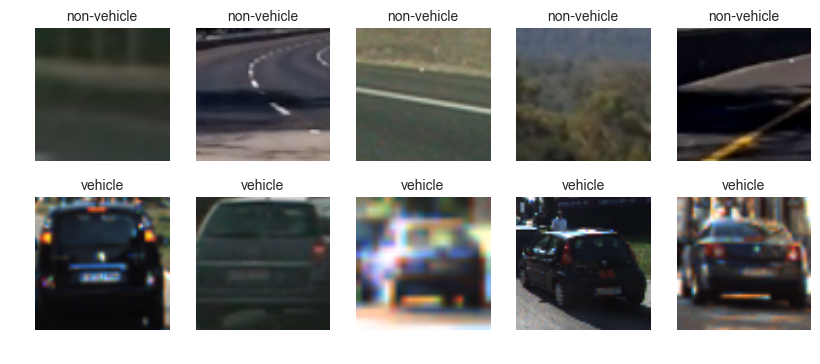

In [9]:
plt.figure(figsize=(10, 4))

show_samples_per_class = 5
img_num = 1

classes = data['label'].unique()
for label in classes:
    for i in range(show_samples_per_class):
        plt.subplot(num_classes, show_samples_per_class, img_num)   
        img_num += 1
        img = get_image(data, label)
        plt.imshow(img)
        plt.title("{}".format(label), fontsize=10)
        plt.axis('off')

## Divide dataset into Vehicle & Non-Vehicle

In [10]:
data_vehicle = []
data_non_vehicle = []

for index, row in data.iterrows():
    image_path = row['image_path']
    label = row['label']
    
    if label == 'vehicle':
        data_vehicle.append(image_path)
    else:
        data_non_vehicle.append(image_path)
        
print("Vehicle dataset has {} elements".format(len(data_vehicle)))
print("Non Vehicle dataset has {} elements".format(len(data_non_vehicle)))

Vehicle dataset has 8792 elements
Non Vehicle dataset has 9666 elements


### Visualize: Hog Features

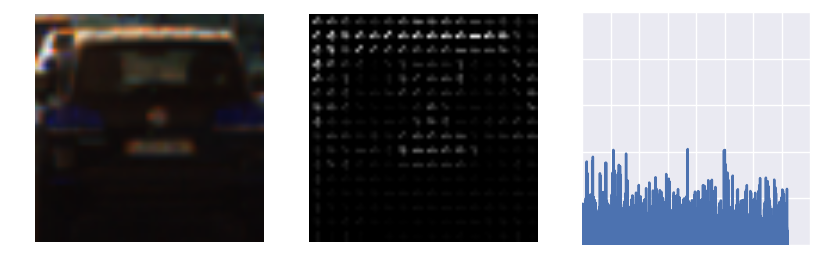

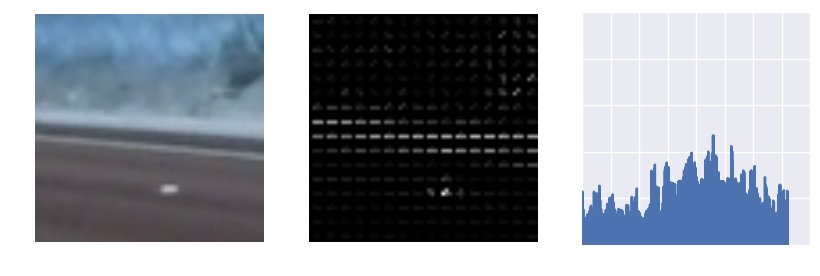

In [11]:
def plot_hog_sample(image, hog_image, hog_features):
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.plot(hog_features)
    plt.ylim(0,1)
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()

# plot positive image
image = get_random_image(data_vehicle)
hog_features, hog_image = get_hog_features(image, vis=True)
plot_hog_sample(image, hog_image, hog_features)

# plot negative image
image = get_random_image(data_non_vehicle)
hog_features, hog_image = get_hog_features(image, vis=True)
plot_hog_sample(image, hog_image, hog_features)

### Visualize: Color histogram

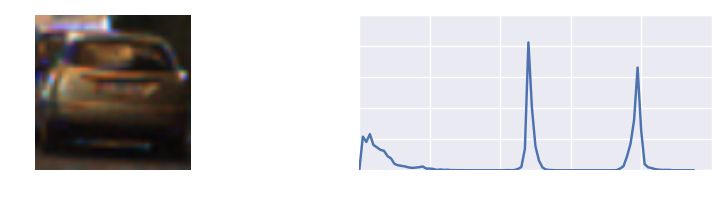

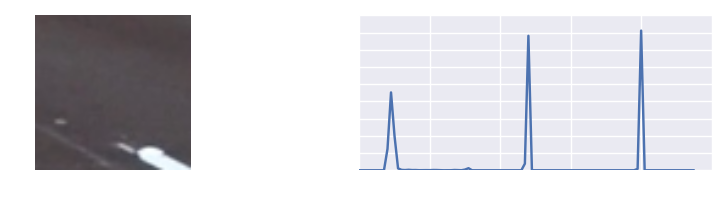

In [12]:
def plot_color_histogram_sample(image):
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.plot(color_hist(image, cspace='YUV'))
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()
    
# plot positive image
image = get_random_image(data_vehicle)
plot_color_histogram_sample(image)

# plot negative image
image = get_random_image(data_non_vehicle)
plot_color_histogram_sample(image)

## Visualize: Binned color

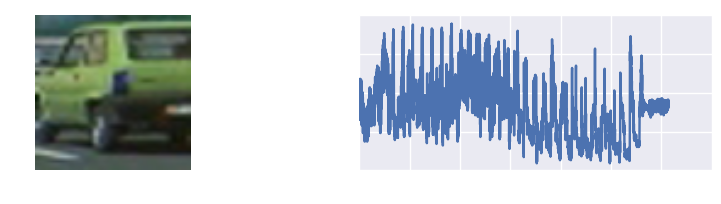

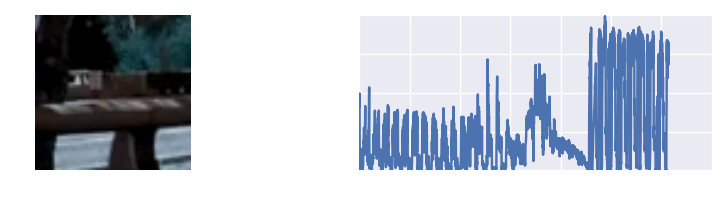

In [13]:
def plot_bin_spatial_sample(image):
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.plot(bin_spatial(image))
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()

# plot positive image
image = get_random_image(data_vehicle)
plot_bin_spatial_sample(image)

# plot negative image
image = get_random_image(data_non_vehicle)
plot_bin_spatial_sample(image)

## Extract, Save, Load features

In [14]:
from os.path import isfile
import pickle

def extract_save_load_features(features_file, dataset):
    
    features = []
    
    if not(isfile(features_file)):

        # generate features
        for image_path in tqdm_notebook(dataset):
            img = read_image(image_path)
            features.append(extract_features(img))

        # save
        with open(features_file, 'wb') as handle:
            pickle.dump(features, handle)
    
    # load
    with open(features_file, 'rb') as handle:
        features = pickle.load(handle)
    
    return features

vehicle_features_file = GEN_FOLDER + '/vehicle_features.pkl'
non_vehicle_features_file = GEN_FOLDER + '/non_vehicle_features.pkl'

vehicle_features = extract_save_load_features(vehicle_features_file, data_vehicle)
non_vehicle_features = extract_save_load_features(non_vehicle_features_file, data_non_vehicle)

print('vehicle_features len:', len(vehicle_features))
print('non_vehicle_features len:', len(non_vehicle_features))



vehicle_features len: 8792
non_vehicle_features len: 9666


## Consolidate features and labels

In [15]:
vehicle_labels = np.ones(len(vehicle_features))
non_vehicle_labels = np.zeros(len(non_vehicle_features))

X = np.concatenate((vehicle_features, non_vehicle_features))
y = np.concatenate((vehicle_labels, non_vehicle_labels))

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (18458, 10368)
y shape: (18458,)


## Apply PCA reduction

Total explained variance by 25 principal components: 0.8218


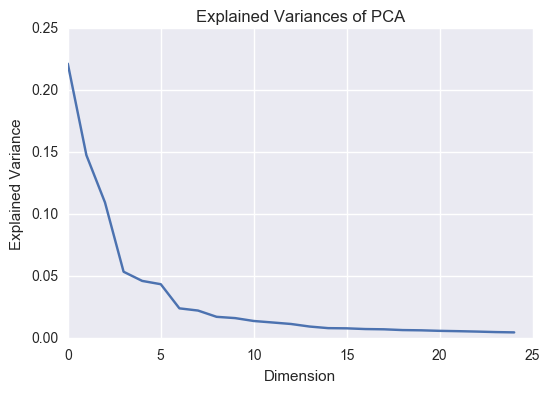

In [16]:
from sklearn.decomposition import RandomizedPCA, PCA

n_comp = 25

pca = PCA(n_components=n_comp, whiten=True)
pca = pca.fit(X)
pca_features = pca.transform(X)

explained_variance = pca.explained_variance_ratio_
components = pca.components_

print("Total explained variance by {} principal components: {:.4f}".format(n_comp, sum(explained_variance[:n_comp])))

# plot pca
plt.xlabel('Dimension')
plt.ylabel('Explained Variance')
plt.title("Explained Variances of PCA")
_ = plt.plot(pca.explained_variance_ratio_)

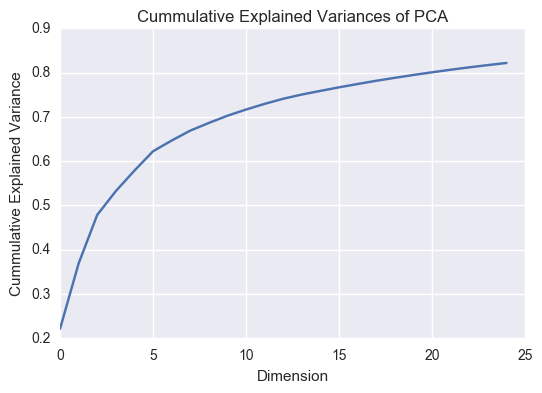

In [17]:
plt.xlabel('Dimension')
plt.ylabel('Cummulative Explained Variance')
plt.title("Cummulative Explained Variances of PCA")
_ = plt.plot(np.cumsum(pca.explained_variance_ratio_))

## Split Train Test dataset

In [18]:
X_train, X_test, y_train, y_test = train_test_split(pca_features, y, test_size=0.1, random_state=seed)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (16612, 25)
X_test shape: (1846, 25)
y_train shape: (16612,)
y_test shape: (1846,)


## Train SVM classifier

In [19]:
from sklearn.svm import SVC

clf_svc = SVC(kernel='rbf', class_weight='balanced',probability=True, C = 10,gamma = 0.1)
clf_svc.fit(X_train, y_train)
print(clf_svc)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## Save Model

In [20]:
from sklearn.externals import joblib

fn = GEN_FOLDER + '/vehicle_vs_non_vehicle_model.pkl'
joblib.dump(clf_svc, fn) 

## save pca
fn = GEN_FOLDER + '/vehicle_vs_non_vehicle_pca.pkl'
joblib.dump(pca, fn) 

print('model, pca saved')

model, pca saved


## Make predictions

In [21]:
acc = clf_svc.score(X_test, y_test)
print('Accuracy on test data is {}'.format(acc))

predictions = clf_svc.predict(X_test)

Accuracy on test data is 0.9929577464788732


## Metrics and Confusion matrix

In [22]:
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=None):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=cmap)
    
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

    plt.title(title+ "\n")
    fig.colorbar(cax)
    if labels:
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(GEN_FOLDER + '/confusionmatrix.png')

accuracy_score: 0.992957746479
f1_score: 0.992957281472
precision_score: 0.99295323285
recall_score: 0.992961912979


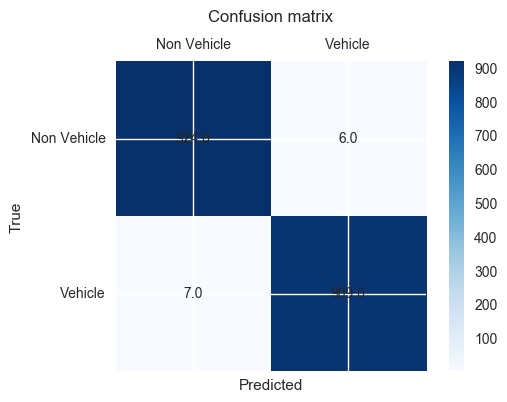

In [23]:
# calculate metrics
print("accuracy_score:", accuracy_score(y_test, predictions))
print("f1_score:", f1_score(y_test, predictions, average="macro"))
print("precision_score:", precision_score(y_test, predictions, average="macro"))
print("recall_score:", recall_score(y_test, predictions, average="macro")) 

# sklearn confusion matrix 
cm = confusion_matrix(predictions, y_test)

# plot using matplotlib
plot_confusion_matrix(cm, labels = ['Non Vehicle', 'Vehicle'])

## Examples of wrong predictions

In [24]:
# ind_wrong = np.argwhere(predictions != y_test)

I don't think we can plot this. We don't have image paths to track back and plot.

## Plot ROC curve

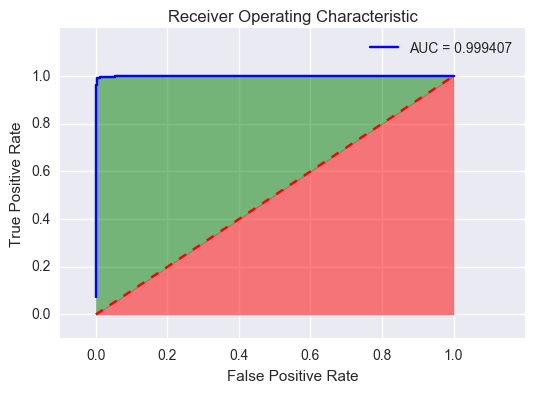

In [25]:
prediction_probabilities = clf_svc.predict_proba(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prediction_probabilities[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.6f'% roc_auc)
plt.legend(loc='upper right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.fill_between(false_positive_rate, false_positive_rate, true_positive_rate, color='green', alpha=0.5)
plt.fill_between(false_positive_rate, 0*false_positive_rate, false_positive_rate, color='red',alpha=0.5)
plt.show()
